Relevant Feature Extraction with SHAP
===

Avicenna uses a pattern matching approach to learn and relations between input elements. Matching all input elements (features) and assosiating their relation with the program behavior is not feasible. Thus, **Avicenna** uses a machine learning model to differentiate between passing and failing inputs (based on the input properties) and then uses [SHAP]() to extract the input elements that have the highest influence on the prediction outcome.

In the following notebook, we will demonstrate how **Avicenna** extracts the most important input elements that are most likely to cause the failure.

#### Example Subject

We use our sample calculator subject to illustrate Avicenna's capabilities. Please refere to the other notebooks, like [calculator.ipynb](./calculator.ipynb), for an in-depth walkthrough of the calculator subject.

In [1]:
from avicenna_formalizations.calculator import grammar, oracle, initial_inputs

In [2]:
for inp in initial_inputs:
    print(inp.ljust(20), oracle(inp))

cos(10)              NO_BUG
sqrt(28367)          NO_BUG
tan(-12)             NO_BUG
sqrt(-900)           BUG


In [3]:
from fuzzingbook.Parser import EarleyParser, tree_to_string

parser = EarleyParser(grammar)
for inp in initial_inputs:
    for tree in parser.parse(inp):
        assert tree_to_string(tree) == inp

## Constructing Feature Vectors

In [4]:
from avicenna.oracle import OracleResult
from avicenna.input import Input
from avicenna.monads import Exceptional
from avicenna.feature_collector import GrammarFeatureCollector

In [5]:
test_inputs = set()
for inp in initial_inputs:
    test_inputs.add(
        Input.from_str(grammar, inp, oracle=oracle(inp))
    )

for inp in test_inputs:
    print(str(type(inp)).ljust(40), str(inp).ljust(20), inp.oracle)

<class 'avicenna.input.Input'>           sqrt(-900)           BUG
<class 'avicenna.input.Input'>           tan(-12)             NO_BUG
<class 'avicenna.input.Input'>           sqrt(28367)          NO_BUG
<class 'avicenna.input.Input'>           cos(10)              NO_BUG


#### Collecting Features

In [6]:
from avicenna.feature_collector import GrammarFeatureCollector, FeatureVector
from avicenna.features import NumericFeature

collector = GrammarFeatureCollector(grammar, feature_types=[NumericFeature])

In [7]:
feature_vector: FeatureVector = collector.collect_features(
    Input.from_str(grammar, "sqrt(-900)")
)

In [8]:
print(feature_vector)

sqrt(-900): {num(<onenine>): 9.0, num(<digit>): 0.0, num(<maybe_frac>): -inf, num(<number>): -900.0, num(<maybe_digits>): 0.0, num(<digits>): 0.0}


In [9]:
from avicenna.features import (
    ExistenceFeature,
    NumericFeature,
    LengthFeature,
    DerivationFeature,
)

features = [
    ExistenceFeature,
    NumericFeature,
    DerivationFeature,
    LengthFeature
]
collector = GrammarFeatureCollector(grammar, feature_types=features)
feature_vector: FeatureVector = collector.collect_features(
    Input.from_str(grammar, "sqrt(-900)")
)
print(feature_vector)

sqrt(-900): {exists(<start>): 1, exists(<arith_expr>): 1, exists(<function>): 1, exists(<number>): 1, exists(<maybe_minus>): 1, exists(<onenine>): 1, exists(<digit>): 1, exists(<maybe_digits>): 1, exists(<digits>): 1, exists(<maybe_frac>): 1, num(<onenine>): 9.0, num(<digit>): 0.0, num(<maybe_frac>): -inf, num(<number>): -900.0, num(<maybe_digits>): 0.0, num(<digits>): 0.0, exists(<start> -> <arith_expr>): 1, exists(<arith_expr> -> <function>(<number>)): 1, exists(<function> -> sqrt): 1, exists(<function> -> sin): 0, exists(<function> -> cos): 0, exists(<function> -> tan): 0, exists(<number> -> <maybe_minus><onenine><maybe_digits><maybe_frac>): 1, exists(<maybe_minus> -> ): 0, exists(<maybe_minus> -> -): 1, exists(<onenine> -> 1): 0, exists(<onenine> -> 2): 0, exists(<onenine> -> 3): 0, exists(<onenine> -> 4): 0, exists(<onenine> -> 5): 0, exists(<onenine> -> 6): 0, exists(<onenine> -> 7): 0, exists(<onenine> -> 8): 0, exists(<onenine> -> 9): 1, exists(<digit> -> 0): 1, exists(<digit> 

In [10]:
for inp in test_inputs:
    inp.update_features(collector.collect_features(inp))
    #print(inp.features)

## Using _SHAP_ to Learn Most Influential Input Propterties

In [11]:
from avicenna import feature_extractor

In [12]:
feature_learner = feature_extractor.DecisionTreeRelevanceLearner(
    grammar, prune_parent_correlation=False
)
(
    relevant_features,
    correlating_features,
    excluded_features,
) = feature_learner.learn(test_inputs)

In [13]:
print(relevant_features)

{exists(<onenine> -> 9)}


In [14]:
feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
)

In [15]:
rel, corr, ex = feature_learner.learn(test_inputs)

In [16]:
from isla.fuzzer import GrammarFuzzer
import copy

gold_standard_size = 1000
reduced_size = 75

fuzzer = GrammarFuzzer(grammar)

gold_standard_inputs = set()
for _ in range(gold_standard_size):
    inp = fuzzer.fuzz_tree()
    new_input = Input(inp, oracle(inp))
    while new_input in gold_standard_inputs:
        inp = fuzzer.fuzz_tree()
        new_input = Input(inp, oracle(inp))
    gold_standard_inputs.add(new_input)

comparison_inputs = set()
for _ in range(reduced_size):
    inp = fuzzer.fuzz_tree()
    new_input = Input(inp, oracle(inp))
    while new_input in comparison_inputs:
        inp = fuzzer.fuzz_tree()
        new_input = Input(inp, oracle(inp))
    comparison_inputs.add(new_input)

for inp in gold_standard_inputs:
    inp.update_features(collector.collect_features(inp))

for inp in comparison_inputs:
    inp.update_features(collector.collect_features(inp))

In [17]:
from avicenna.input_reducer import determine_input_subset, create_feature_table,generate_feature_vectors

inputs = determine_input_subset(gold_standard_inputs, grammar, reduced_size, use_PCA=False, quantitative_feature_weight=1.5, metric=1)

before dim reduction: (1000, 60)
removed constant: (1000, 48)
removed redundant: (1000, 43)


In [18]:
import statistics
import re

def bold(text):
    return "\033[1m" + text + "\033[0m"

def underline(text):
    return "\u0332" + (text) + "\u0332"

def set_info(set, name = "Set"):
    print(f"{bold(name)} ({len(set)})")
    sqrt_cnt = 0
    tan_cnt = 0
    sin_cnt = 0
    cos_cnt = 0
    negative_cnt = 0
    num_list = []
    for inp in set:
        inp = str(inp)
        num = float(re.findall("-?\d+\.?\d*", inp)[0])
        if num is not None:
            num_list.append(num)
        if "sqrt" in inp:
            sqrt_cnt +=  1
        elif "tan" in inp:
            tan_cnt +=  1
        elif "sin" in inp:
            sin_cnt += 1
        elif "cos" in inp:
            cos_cnt += 1
        if "-" in inp:
            negative_cnt += 1
    distance_sum = 0
    cnt = 0
    for num1 in num_list:
        for num2 in num_list:
            if num1 != num2:
                cnt += 1
                distance_sum += abs(num1 - num2)
    distance_average = distance_sum / float(cnt)
    print(f"Standard deviation: {statistics.stdev(num_list):,.0f}")
    print(f"Average distance between numbers: {distance_average:,.0f}")
    print(f"sqrt: {sqrt_cnt}, tan: {tan_cnt}, sin: {sin_cnt}, cos: {cos_cnt} | negative: {negative_cnt}")

In [19]:
set_info(gold_standard_inputs, "gold_standard_inputs")
set_info(inputs, "reduced_inputs")
set_info(comparison_inputs, "comparison_inputs")

gold_standard_inputs (1000)
Standard deviation: 657,760,413,104,698
Average distance between numbers: 41,635,077,743,779
sqrt: 259, tan: 252, sin: 230, cos: 259 | negative: 480
reduced_inputs (75)
Standard deviation: 2,401,809,690,417,854
Average distance between numbers: 554,825,287,909,839
sqrt: 32, tan: 18, sin: 16, cos: 9 | negative: 35
comparison_inputs (75)
Standard deviation: 124,257,021
Average distance between numbers: 47,955,309
sqrt: 29, tan: 13, sin: 17, cos: 16 | negative: 42


In [20]:
feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
    show_beeswarm_plot=True
)

Gold standard


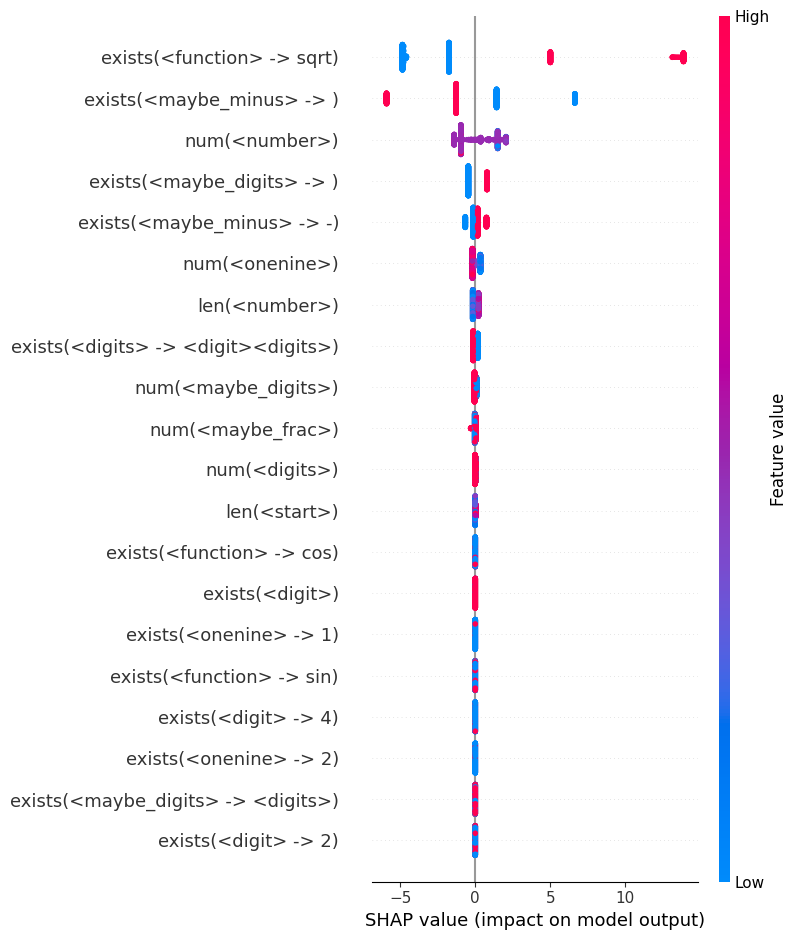

Reduced Set


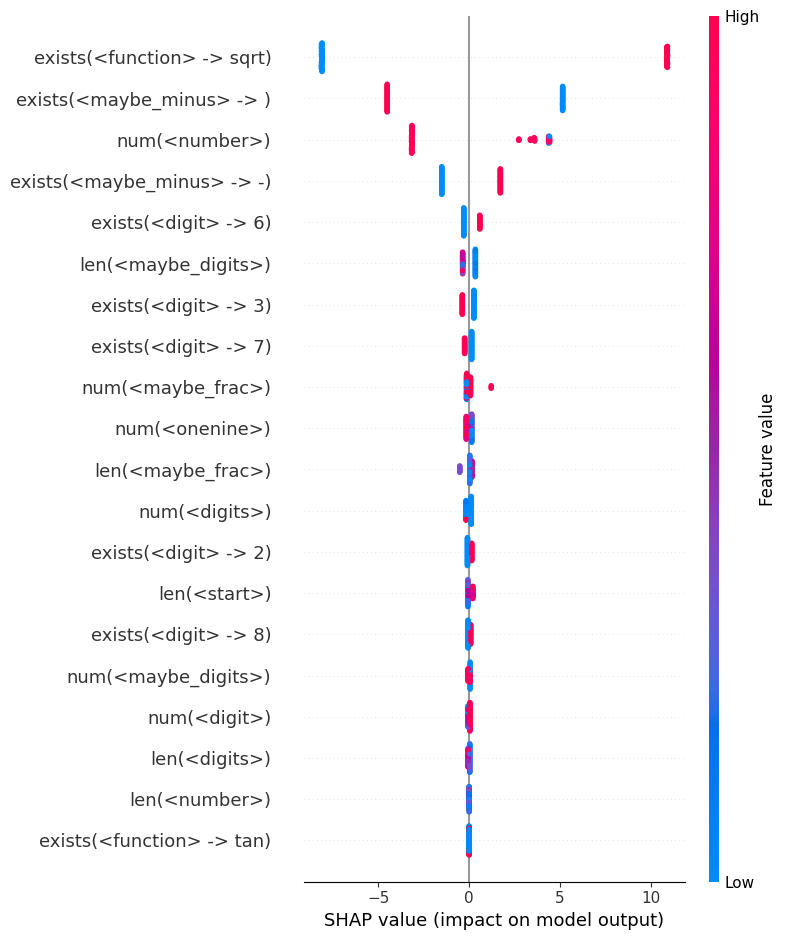

Comparison Set


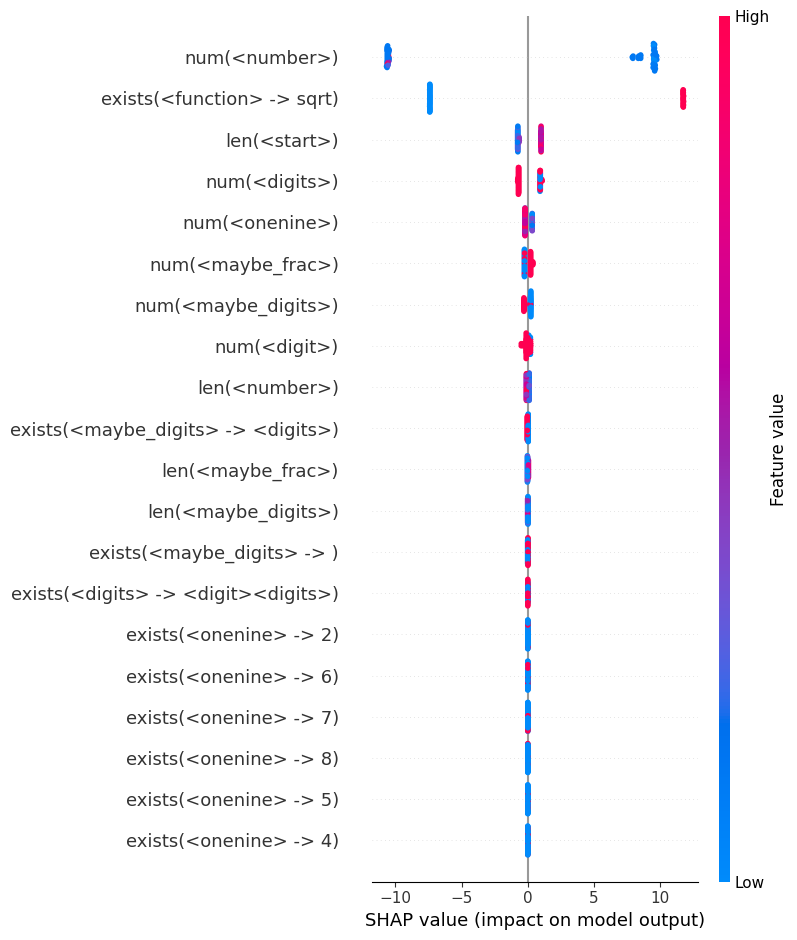

In [21]:
print("Gold standard")
relevant_features_gs, correlating_features_gs, _ = feature_learner.learn(gold_standard_inputs)
print("Reduced Set")
relevant_features_rs, correlating_features_rs, _ = feature_learner.learn(inputs)
print("Comparison Set")
relevant_features_cs, correlating_features_cs, _ = feature_learner.learn(comparison_inputs)

In [22]:
# gold standard
relevant_features_gs

{exists(<function> -> sqrt), exists(<maybe_minus> -> )}

In [23]:
# reduced set
relevant_features_rs

{exists(<function> -> sqrt), exists(<maybe_minus> -> )}

In [24]:
# comparison set
relevant_features_cs

{exists(<function> -> sqrt), num(<number>)}

In [25]:
# gold standard
correlating_features_gs

{exists(<maybe_minus> -> -),
 len(<function>),
 len(<maybe_minus>),
 num(<number>)}

In [26]:
# reduced set
correlating_features_rs

{exists(<maybe_minus> -> -),
 len(<function>),
 len(<maybe_minus>),
 num(<number>)}

In [27]:
# comparison set
correlating_features_cs

{len(<function>)}